# 토양 프로파일링 : 성분함량과 수분 특성
- 토양 프로파일 데이터는 식물에 필요한 충분한 수분이 유지되는지를 모니터링하고, 물 부족이 예상될 때 적절한 조치를 췰할 수 있도록 도와줍니다.
- 또한, 식물을 심기에 적합한 시기와 위치를 결정하고 관개 게획을 수립하는 데 있어 중요한 기준이 됩니다.

### Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pprint
import branca.colormap as cm
import ee
import geemap

In [53]:
import matplotlib.font_manager as fm

font_path = 'C:/WINDOWS/Fonts/H2HDRM.TTF'
# 폰트 프로퍼티 설정
font_prop = fm.FontProperties(fname=font_path, size=14)

# matplotlib의 폰트를 설정
plt.rcParams['font.family'] = font_prop.get_name()

### Google Earth API 인증

In [ ]:
import os

os.environ['EARTHENGINE_API_KEY'] = 'Your API key'

In [2]:
# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

### 관심 기간 및 관심 지역 설정

In [3]:
# 관심 기간의 시작일
i_date = "2015-01-01"

# 관심 기간의 종료일
f_date = "2023-11-01"

In [4]:
# 피처 컬렉션을 필터링하여 한국으로 제한
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
korea = countries.filter(ee.Filter.eq("ADM0_NAME", "Republic of Korea"))

korea_geo = korea.geometry()

location = korea_geo.centroid().coordinates().getInfo()[::-1]

In [5]:
# Folium 지도에 레이어 추가 함수
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

### 깊이에 따른 토양 성분 데이터 수집
- 토양을 구성하는 다양한 깊이에서의 모래, 흙, 유기탄소의 함량 데이터를 OpenLandMap 제공되는 데이터셋에서 가져온다 (250m 해상도)

In [7]:
# 토양 성분 수집
def get_soil_prop(param):
    """
        "sand"     - 모래 함량
        "clay"     - 점토 함량
        "orgc"     - 유기 탄소 함량
    """
    if param == "sand":  # 모래 함량 [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 1 * 0.01

    elif param == "clay":  # 점토 함량 [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # 유기 탄소 함량 [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 5 * 0.001  # kg/kg로 변환하기 위함.
    else:
        return print("error")

    # ee.Image에 적용합니다.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset

In [8]:
# 데이터가 있는 토양 깊이 [cm].
olm_depths = [0, 10, 30, 60, 100, 200]

# 참조 깊이와 연결된 밴드 이름.
olm_bands = ["b" + str(sd) for sd in olm_depths]

In [9]:
# 모래 함량과 관련된 이미지.
sand = get_soil_prop("sand")

# 점토 함량과 관련된 이미지.
clay = get_soil_prop("clay")

# 유기 탄소 함량과 관련된 이미지.
orgc = get_soil_prop("orgc")

# 유기 탄소 함량을 유기물 함량으로 변환.
orgm = orgc.multiply(1.724)

In [12]:
# 시들음점과 토양의 최대 수분용량을 위한 두 개의 상수 이미지 초기화.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# 각 표준 깊이에 대한 계산을 루프를 사용하여 수행.
for key in olm_bands:
    # 적절한 깊이에서 모래, 점토, 유기물 얻기.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # 시들음점 계산.
    # 주어진 깊이에 필요한 theta_1500t 매개변수.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
            - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # 시들음점을 위한 최종 식.
    wpi = theta_1500ti.expression(
        "T1500ti + (0.14 * T1500ti - 0.002)", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # 전체 시들음점을 ee.Image에 새 밴드로 추가.
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # 최대 수분용량 계산을 위한 동일한 과정.
    # 주어진 깊이에 필요한 theta_33t 매개변수.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
            0.006 * (S * OM) - 0.027 * (C * OM)+\
            0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # 토양의 최대 수분용량을 위한 최종 식.
    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # 전체 최대 수분용량을 ee.Image에 새 밴드로 추가.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

모래, 점토, 유기탄소 함량을 안다면 수식을 통해 해당 토양의 시들음 시점과 최대 수분용량을 알 수 있다.
- 식물 시들음 시점
    - 식물이 건강하게 성장하기 위해 필요한 최소한의 수분을 가리킵니다.
    - 이보다 낮을 시, 식물이 더 이상 물을 흡수하지 못해 시들기 시작하는 임계점입니다.
    - 예를 들어 시들음점이 10%라면, 해당 토양 수분이 10% 밑으로 떨어질 시 식물은 더이상 물을 공급 받지 못하고 시들게 됩니다.
    - 따라서 시들음점이 높은 토양에서 자라는 식물은 뿌리가 흡수할 수 있는 물이 적기에, 물 부족에 더 민감하게 반응하며 자주 관개가 필요합니다.
    - 따라서, 시들음점을 알면 식물들이 건강하게 자라기 위한 토양 조건을 알 수 있고, 물의 추가 공급 유무를 알 수 있습니다.
- 토양 최대 수분용량
    - 토양이 물을 최대로 저장할 수 있는 시점으로, 그 시점 이후에는 중력에 의해 물이 지하로 침투하기 시작합니다.

In [13]:
# 강수량 데이터 가져오기.
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation")
    .filterDate(i_date, f_date)
    .filterBounds(korea_geo)  # 한국 지역에 대한 필터링.
)

# 잠재 증발산량(PET)과 그 품질 지표(ET_QC) 가져오기.
pet = (
    ee.ImageCollection("MODIS/006/MOD16A2")
    .select(["PET", "ET_QC"])
    .filterDate(i_date, f_date)
    .filterBounds(korea_geo)  # 한국 지역에 대한 필터링.
)

- 강수량 데이터는 Climate Hazards Group InfraRed Precipitation with Station data(CHIRPS)에서 제공되는 데이터셋 (매일 갱신, 해상도 5km)
- 증발산량 데이터는 MODIS Terra Net에서 제공되는 데이터셋 (8일에 한번, 해상도 500m)
    - 증발산량은 증발과 증산을 합친 것으로 증산은 식물이 수분을 흡수하여 잎을 통해 대기중으로 방출하는 것을 말한다.
    - 이 데이터셋에서 제공되는 증발산량은 적설량, 지역의 경사도에서 유출이 심한 점 등을 배제한 데이터로 잠재 증발산량으로 명명한다.

#### 시간 규모에 따른 데이터 재샘플링

In [14]:
# 시간 규모 재샘플링
def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    coll: (ee.ImageCollection) 한 밴드만 처리 가능
    freq: (int) 재샘플링 빈도에 해당
    unit: (str) 재샘플링 시간 단위. 'day', 'month', 'year'이어야 함
    scale_factor (float): 적절한 단위로 값을 얻기 위한 스케일링 인자
    band_name (str) 출력 밴드의 이름
    """

    # 컬렉션의 초기 및 최종 날짜 정의.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )
    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # 두 날짜 사이의 시간 차이 계산.
    diff_dates = lastdate.difference(firstdate, unit)

    # 새로운 시간 인덱스(출력용) 정의.
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # 새 시간 인덱스에 적용할 함수 정의.
    def apply_resampling(date_index):
        # 고려할 시작 날짜 정의.
        startdate = firstdate.advance(ee.Number(date_index), unit)
        # 원하는 빈도에 따라 고려할 종료 날짜 정의.
        enddate = startdate.advance(freq, unit)
        # 시작 및 종료 날짜 사이의 일수 계산.
        diff_days = enddate.difference(startdate, "day")
        # 합성 이미지 계산.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )
        # 적절한 시간 인덱스를 가진 최종 이미지 반환.
        return image.set("system:time_start", startdate.millis())

    # 새 시간 인덱스에 함수 매핑.
    res = new_index.map(apply_resampling)

    # 결과를 ee.ImageCollection으로 변환.
    res = ee.ImageCollection(res)

    return res

In [15]:
# 강수량 데이터셋에 재샘플링 함수 적용.
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

In [16]:
# 증발산량 데이터셋에 재샘플링 함수 적용.
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

▲ 데이터셋을 월별 강수량/증발산량으로 재샘플링
- 해상도 및 데이터를 습득한 시간이 다르므로 재샘플링하여 단위를 맞춰준다.

In [17]:
# 강수량과 증발산량 데이터셋 병합.
meteo = pr_m.combine(pet_m)

#### 토양 깊이에 따른 토양 함량의 평균 값 계산

In [18]:
# 깊이에 따른 토양 속성의 평균 값을 계산하는 함수.
def olm_prop_mean(olm_image, band_output_name):
    """
    식물이 뿌리를 통해 접근할 수 있는 토양 깊이에 걸쳐 있는 수분 함량
    """
    mean_image = olm_image.expression(
        "(b0 + b10 + b30 + b60 + b100 + b200) / 6",
        {
            "b0": olm_image.select("b0"),
            "b10": olm_image.select("b10"),
            "b30": olm_image.select("b30"),
            "b60": olm_image.select("b60"),
            "b100": olm_image.select("b100"),
            "b200": olm_image.select("b200"),
        },
    ).rename(band_output_name)

    return mean_image

In [19]:
zr = ee.Image(0.5)
p = ee.Image(0.5)

zr은 식물의 뿌리 깊이에 대한 비율을

p는 필드 용량에 대한 토양의 현재 수분 함량 비율을 나타낸다

In [20]:
# 필드 용량과 시듦점에 함수 적용.
fcm = olm_prop_mean(field_capacity, "fc_mean")
wpm = olm_prop_mean(wilting_point, "wp_mean")

# 이론적으로 사용 가능한 물 계산
# 토양 최대 수분용량 - 시들음점 차이 계산
taw = (
    (fcm.select("fc_mean").subtract(wpm.select("wp_mean"))).multiply(1000).multiply(zr)
)

# 토양 최대 수분용량에 저장된 물 계산.
stfc = taw.multiply(p)

시들음점과 토양 최대 수분용량을 통해 다음과 같은 식을 도출할 수 있다.
- TAW = 1000 * (토양 최대 수분용량 - 시들음점) * 뿌리깊이
- `TAW`는 식물이 건강하게 성장할 수 있음과 동시에 사용가능한 물의 양을 나타낸다.
- TAW에 0과 1사이의 임의의 p값을 곱한 값이 `STFC`로 토양이 해당뿌리깊이에 해당하는 실제 수분량을 뜻한다.

#### 초기 상태 설정
    - 지하수 재충전량을 시간에 따라 추정하기 위해

In [21]:
# 컬렉션의 시작에 따라 초기 시간(time0)을 정의합니다.
time0 = meteo.first().get("system:time_start")

In [22]:
# 토양의 수분 상태를 설명하는 모든 밴드를 초기화합니다.
# 데이터 유형을 .float()로 형변환하는 것을 잊지 마세요.

# 초기 재충전량 설정.
initial_rech = ee.Image(0).set("system:time_start", time0).select([0], ["rech"]).float()

# 누적 잠재적 수분 손실(APWL) 초기화.
initial_apwl = ee.Image(0).set("system:time_start", time0).select([0], ["apwl"]).float()

# 저장된 수분 초기화.
initial_st = stfc.set("system:time_start", time0).select([0], ["st"]).float()

# 강수량 초기화.
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# 잠재 증발산량 초기화.
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

In [23]:
# 초기 재충전 이미지에 다른 밴드들을 추가하여 모든 밴드를 하나의 이미지로 결합합니다.
initial_image = initial_rech.addBands(
    ee.Image([initial_apwl, initial_st, initial_pr, initial_pet])
)

# 생성된 이미지를 리스트에 추가합니다. 이 리스트는 시계열 분석에서 사용됩니다.
image_list = ee.List([initial_image])

#### 지하수 재충전량 계산

In [24]:
def recharge_calculator(image, image_list):

    # 현재 ee.Image 컬렉션의 날짜 결정.
    localdate = image.date().millis()

    # 리스트에 저장된 이전 이미지 가져오기.
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # 이전 APWL과 ST 가져오기.
    prev_apwl = prev_im.select("apwl")
    prev_st = prev_im.select("st")

    # 현재 강수량과 증발산량 가져오기.
    pr_im = image.select("pr")
    pet_im = image.select("pet")

    # 재충전, APWL, ST와 관련된 새로운 밴드 초기화
    new_rech = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["rech"])
        .float()
    )
    new_apwl = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["apwl"])
        .float()
    )
    new_st = (
        prev_st.set("system:time_start", localdate).select([0], ["st"]).float()
    )

    # 조건에 따라 밴드 계산 수행

    # CASE 1: PET > P 일 경우 (증발산량 > 강수량)
    zone1 = pet_im.gt(pr_im)
    # zone1에서 APWL(누적 잠재적 수분 손실) 계산
    zone1_apwl = prev_apwl.add(pet_im.subtract(pr_im)).rename("apwl")
    # zone1의 APWL 값 구현
    new_apwl = new_apwl.where(zone1, zone1_apwl)
    # zone1에서 ST(저장 수분) 계산
    zone1_st = prev_st.multiply(
        ee.Image.exp(zone1_apwl.divide(stfc).multiply(-1))
    ).rename("st")
    # zone1의 ST 값 구현
    new_st = new_st.where(zone1, zone1_st)

    # CASE 2: PET <= P 일 경우 (증발산량 <= 강수량)
    zone2 = pet_im.lte(pr_im)
    # zone2에서 ST 계산.
    zone2_st = prev_st.add(pr_im).subtract(pet_im).rename("st")
    # zone2의 ST 값 구현.
    new_st = new_st.where(zone2, zone2_st)

    # CASE 2.1: PET <= P 및 ST >= STfc 일 경우
    zone21 = zone2.And(zone2_st.gte(stfc))
    # zone21에서 재충전 계산 즉, 필드 용량 이상의 수분이 있을때, 재충전량 계산
    zone21_re = zone2_st.subtract(stfc).rename("rech")
    # zone21의 재충전 값 구현.
    new_rech = new_rech.where(zone21, zone21_re)
    # zone21의 ST 값 구현.
    new_st = new_st.where(zone21, stfc)

    # CASE 2.2: PET <= P 및 ST < STfc 일 경우 즉, 필드 용량 미만의 수분이 있을때
    zone22 = zone2.And(zone2_st.lt(stfc))
    # zone22에서 APWL 계산.
    zone22_apwl = (
        stfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(stfc))).rename("apwl")
    )
    # zone22의 APWL 값 구현.
    new_apwl = new_apwl.where(zone22, zone22_apwl)

    # 재충전 계산이 가능한 영역 주위에 마스크 생성.
    mask = pet_im.gte(0).And(pr_im.gte(0)).And(fcm.gte(0)).And(wpm.gte(0))
    # 마스크 적용.
    new_rech = new_rech.updateMask(mask)

    # 모든 밴드를 새로운 ee.Image에 추가.
    new_image = new_rech.addBands(ee.Image([new_apwl, new_st, pr_im, pet_im]))

    # 새로운 ee.Image를 ee.List에 추가.
    return ee.List(image_list).add(new_image)

In [25]:
# 사용자 정의 함수를 기상 데이터 컬렉션에 적용.
rech_list = meteo.iterate(recharge_calculator, image_list)

# 리스트에서 초기 이미지 제거.
rech_list = ee.List(rech_list).remove(initial_image)

# 리스트를 ee.ImageCollection으로 변환.
rech_coll = ee.ImageCollection(rech_list)

In [26]:
# 연평균 지하수 재충전량 계산
annual_rech = rech_coll.select("rech").mean().multiply(12)

# 연평균 강수량 계산
annual_pr = rech_coll.select("pr").mean().multiply(12)

In [27]:
# 관심 지역 주변에 컴포지트 ee.Images 클리핑.
rech_korea = annual_rech.clip(korea)
pr_korea = annual_pr.clip(korea)

In [28]:
# folium 지도 생성
my_map = folium.Map(location=location, zoom_start=6, zoom_control=False)

# 지하수 재충전률 시각화 파라미터 설정
rech_vis_params = {
    "bands": "rech",
    "min": 0,
    "max": 500,
    "opacity": 1,
    "palette": ["red", "orange", "yellow", "green", "blue", "purple"],
}

# 강수량 시각화 파라미터 설정
pr_vis_params = {
    "bands": "pr",
    "min": 500,
    "max": 1500,
    "opacity": 1,
    "palette": ["white", "blue"],
}

# 지하수 재충전률 컬러맵 정의
rech_colormap = cm.LinearColormap(
    colors=rech_vis_params["palette"],
    caption="Average annual recharge rate (mm/year)",
    vmin=rech_vis_params["min"],
    vmax=rech_vis_params["max"],
)

# 강수량 컬러맵 정의
pr_colormap = cm.LinearColormap(
    colors=pr_vis_params["palette"],
    caption= "Average annual precipitation rate (mm/year)",
    vmin=pr_vis_params["min"],
    vmax=pr_vis_params["max"],
)

# 강수량 컴포지트를 지도 객체에 추가
my_map.add_ee_layer(pr_korea, pr_vis_params, "Precipitation")

# 지하수 재충전률 컴포지트를 지도 객체에 추가
my_map.add_ee_layer(rech_korea, rech_vis_params, "Recharge")

# 컬러맵을 지도에 추가
my_map.add_child(rech_colormap)
my_map.add_child(pr_colormap)

# 지도에 레이어 컨트롤 패널 추가
my_map.add_child(folium.LayerControl())

# 지도 표시
display(my_map)

지하수 재충전량은 강수로부터 지하수 표면에 도달하는 물의 양을 의미한다.
- 빨간 계열 즉, 밝은 색은 낮은 강수량과 낮은 재충전량을

  파란 계열 즉, 어두운 색은 높은 강수량 또는 높은 재충전량을 의미

In [32]:
# 한국 내 관심 지역 좌표 삽입
lon = 127.26520600000002
lat = 36.345211
poi = ee.Geometry.Point(lon, lat)

# 분석에 사용할 투영의 명목상의 해상도 [단위: 미터].
scale = 1000

In [33]:
# 지도 객체를 초기화할 때 중심점 사용
my_map = folium.Map(location=[lat, lon], zoom_start=8)

# 시각화 매개변수 설정
vis_params = {
    "bands": ["b0"],
    "min": 0.01,
    "max": 1,
    "opacity": 1,
    "palette": ["white", "#464646"],
}

# 모래 함량 데이터를 지도 객체에 추가
my_map.add_ee_layer(sand, vis_params, "Sand Content")

# 점토 함량 데이터를 지도 객체에 추가
my_map.add_ee_layer(clay, vis_params, "clay Content")

# 유기 탄소 함량 데이터를 지도 객체에 추가
my_map.add_ee_layer(orgc, vis_params, "orgc Content")

# 국립공원 경계에 마커 추가
folium.Marker([lat, lon], popup="관심영역 중심점").add_to(my_map)

# 지도에 레이어 컨트롤 패널 추가
my_map.add_child(folium.LayerControl())

# 지도 표시
display(my_map)

▲ 한국의 모래, 흙, 유기탄소 함량 시각화

In [34]:
# 관심지역의 토양 성분 추출
def local_profile(dataset, poi, buffer):
    """
    buffer: 샘플링 범위 (미터 단위)
    """
    # 관심 지역에서 속성을 얻습니다.
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()

    # 관심 있는 특성을 선택합니다.
    profile = prop["features"][0]["properties"]

    # 딕셔너리를 재구성합니다.
    profile = {key: round(val, 3) for key, val in profile.items()}

    return profile

# 함수를 적용하여 모래 함량 프로필을 얻습니다.
profile_sand = local_profile(sand, poi, scale)

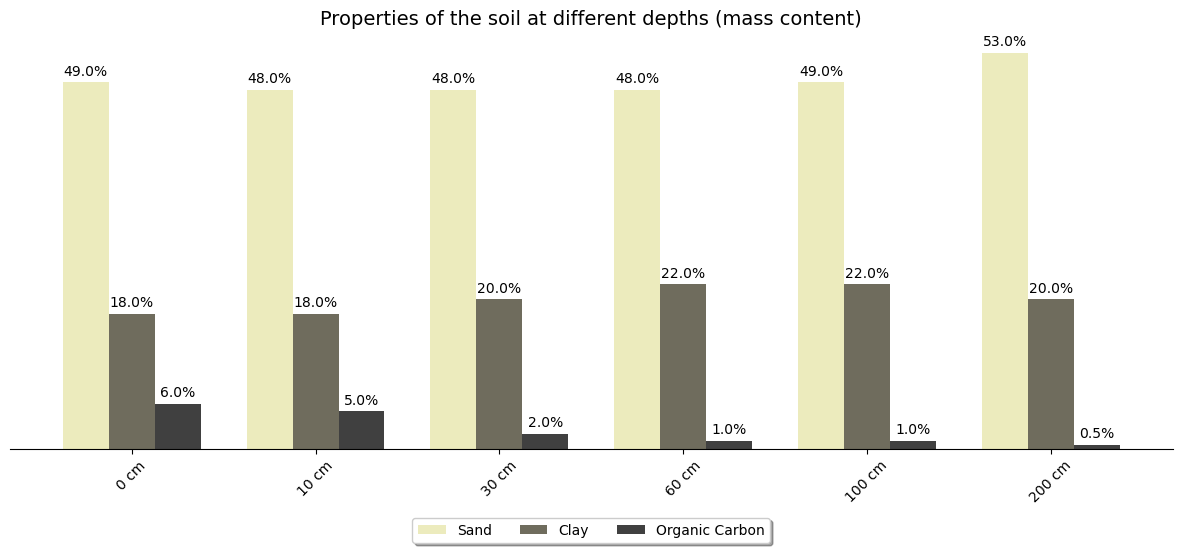

In [35]:
# 점토 및 유기 탄소 함량 프로필.
profile_clay = local_profile(clay, poi, scale)
profile_orgc = local_profile(orgc, poi, scale)

# 막대 그래프 형태의 데이터 시각화.
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# 라벨 위치 정의.
x = np.arange(len(olm_bands))

# 막대 너비 정의.
width = 0.25

# 모래 함량 프로필을 나타내는 막대 그래프.
rect1 = ax.bar(
    x - width,
    [round(100 * profile_sand[b], 2) for b in olm_bands],
    width,
    label="모래",
    color="#ecebbd",
)

# 점토 함량 프로필을 나타내는 막대 그래프.
rect2 = ax.bar(
    x,
    [round(100 * profile_clay[b], 2) for b in olm_bands],
    width,
    label="흙",
    color="#6f6c5d",
)

# 유기 탄소 함량 프로필을 나타내는 막대 그래프.
rect3 = ax.bar(
    x + width,
    [round(100 * profile_orgc[b], 2) for b in olm_bands],
    width,
    label="유기 탄소",
    color="black",
    alpha=0.75,
)

# 각 막대에 라벨을 붙이는 함수 정의.
def autolabel_soil_prop(rects):
    """각 막대(*rects*) 위에 텍스트 라벨을 부착하여 높이를 표시합니다."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height) + "%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 수직 오프셋 3포인트.
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )

# 각 막대 그래프에 함수 적용.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)
autolabel_soil_prop(rect3)

# 그래프 제목 설정.
ax.set_title("깊이에 따른 토양 성분 (함량)", fontsize=14)

# x/y 라벨 및 눈금 속성 설정.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# 현재 축의 높이를 아래쪽으로 10% 축소.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# 현재 축 아래에 범례 추가.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3
)

plt.show()

▲ 깊이에 따른 관심 지역의 모래, 흙, 유기 탄소 함량 히스토그램

In [36]:
profile_wp = local_profile(wilting_point, poi, scale)
profile_fc = local_profile(field_capacity, poi, scale)

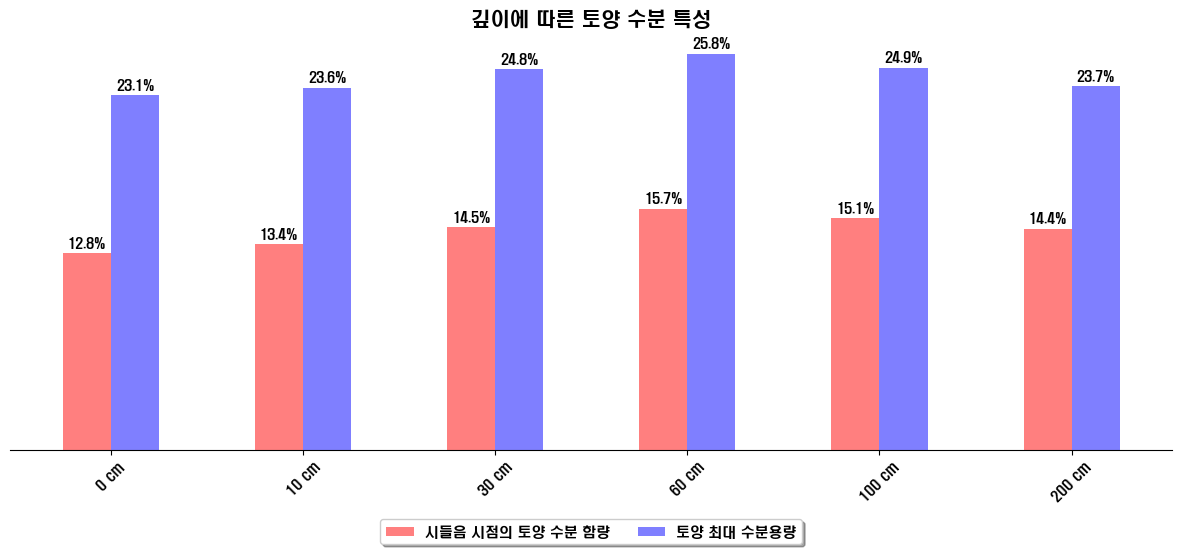

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# 라벨 위치 정의.
x = np.arange(len(olm_bands))

# 막대 그래프의 너비 정의.
width = 0.25

# 시듦점에서의 물 함량과 관련된 막대 그래프.
rect1 = ax.bar(
    x - width / 2,
    [round(profile_wp[b] * 100, 2) for b in olm_bands],
    width,
    label="시들음 시점의 토양 수분 함량",
    color="red",
    alpha=0.5,
)

# 수분용량에서의 물 함량과 관련된 막대 그래프.
rect2 = ax.bar(
    x + width / 2,
    [round(profile_fc[b] * 100, 2) for b in olm_bands],
    width,
    label="토양 최대 수분용량",
    color="blue",
    alpha=0.5,
)

# 각 막대 위에 라벨 추가.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)

# 그래프 제목 설정.
ax.set_title("깊이에 따른 토양 수분 특성", fontsize=14)

# x/y 라벨 및 눈금 속성 설정.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# 현재 축의 높이를 아래쪽으로 10% 축소.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# 현재 축 아래에 범례 추가.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

▲ 관심 지역의 시들음점, 토양 최대 수분용량 시각화

In [39]:
# 관심 지역에서 기상 데이터를 배열로 가져옴.
meteo_arr = meteo.getRegion(poi, scale).getInfo()

In [41]:
def ee_array_to_df(arr, list_of_bands):
    # 데이터 배열을 데이터프레임으로 변환.
    df = pd.DataFrame(arr)

    # 헤더 재배열.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # 데이터를 숫자 값으로 변환.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # 'time' 필드를 datetime으로 변환.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # 관심 있는 컬럼만 유지.
    df = df[["time", "datetime", *list_of_bands]]

    # 'datetime' 컬럼을 인덱스로 설정.
    df = df.set_index("datetime")

    return df

In [46]:
# 지하수 재충전 컬렉션에서 관심 지역의 데이터를 배열로 가져옴.
arr = rech_coll.getRegion(poi, scale).getInfo()

# 배열을 pandas 데이터프레임으로 변환하고 인덱스를 정렬.
rdf = ee_array_to_df(arr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()

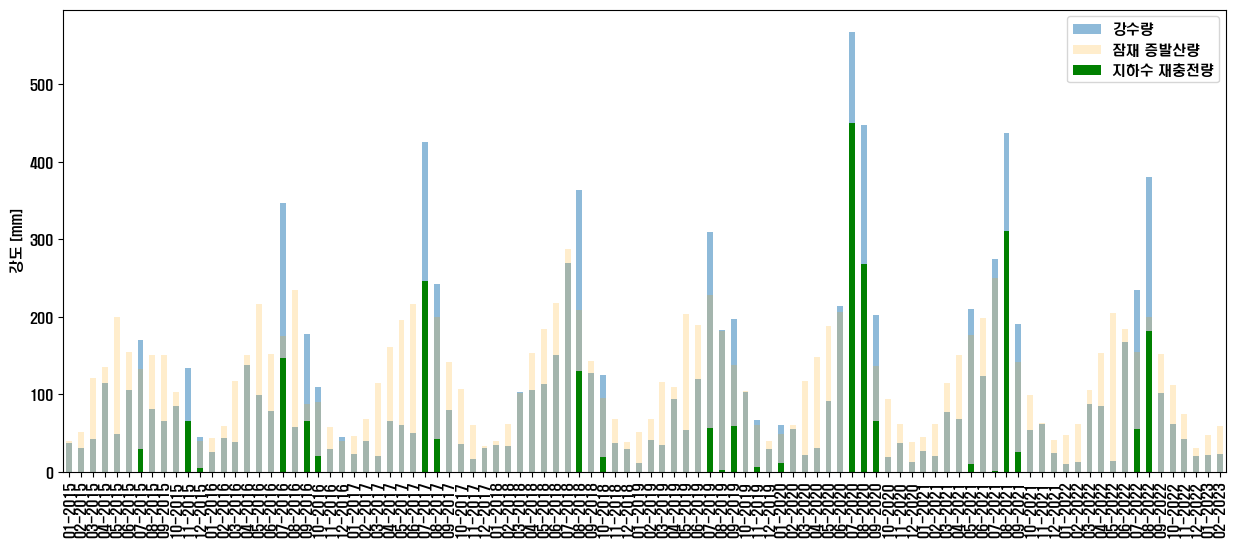

In [56]:
# 데이터 시각화를 막대 그래프 형태로 진행
fig, ax = plt.subplots(figsize=(15, 6))

# 강수량에 대한 막대 그래프
rdf["pr"].plot(kind="bar", ax=ax, label="강수량", alpha=0.5)

# 잠재 증발산량에 대한 막대 그래프
rdf["pet"].plot(
    kind="bar", ax=ax, label="잠재 증발산량", color="orange", alpha=0.2
)

# 지하수 재충전량에 대한 막대 그래프
rdf["rech"].plot(kind="bar", ax=ax, label="지하수 재충전량", color="green", alpha=1)

# 범례 추가
ax.legend()

# x/y축 라벨 정의
ax.set_ylabel("강도 [mm]")
ax.set_xlabel(None)

# x축 라벨의 날짜 형식과 모양 정의
x_labels = rdf.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

▲ 해당 관심 지역의 월 평균 강수량, 잠재증발산량, 지하수 재충전량 시각화 
- 관심 지역에서 지하수 재충전이 일반적으로 언제 일어나는지와 강수량은 높으나 높은 온도와 햇빛 노출 등으로 인해 증발산이 많이 일어나는 때를 파악 가능
- 지하수 재충전의 조건은 강수량이 잠재적 증발산보다 높음과 동시에 해당 토양의 수분이 포화상태일 때 지하수로 모이게 된다

In [50]:
# pandas 데이터프레임을 연간 기준으로 재표본하여 연간 합계를 계산합니다.
rdfy = rdf.resample("Y").sum()

# 평균값을 계산합니다.
mean_recharge = rdfy["rech"].mean()

# 결과를 출력합니다.
print("우리 관심 지역의 연평균 지하수 재충전량은", int(mean_recharge), "mm/년 입니다.")

우리 관심 지역의 연평균 지하수 재충전량은 251 mm/년 입니다.


In [44]:
def get_local_recharge(i_date, f_date, lon, lat, scale):
    """
    주어진 기간 동안 지정된 위치에서 월별 누적 지하수 재충전량을 설명하는 pandas DataFrame을 반환합니다.
    """
    # 관심 지역의 경계 정의
    poi = ee.Geometry.Point(lon, lat)

    # 관심 지역 주변의 재충전을 평가합니다.
    rarr = rech_coll.filterDate(i_date, f_date).getRegion(poi, scale).getInfo()

    # 결과를 pandas 데이터프레임으로 변환합니다.
    rdf = ee_array_to_df(rarr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()
    return rdf

In [55]:
# 관심 지역 경계를 가져옵니다.
lon2 = 127.20357831431272
lat2 = 37.22987487201979

# 해당 위치에서 로컬 재충전 상태를 계산합니다.
rdf2 = get_local_recharge(i_date, f_date, lon2, lat2, scale)

# 결과 pandas 데이터프레임을 연간 기준으로 재표본화합니다 (연간 합계).
rdf2y = rdf2.resample("Y").sum()

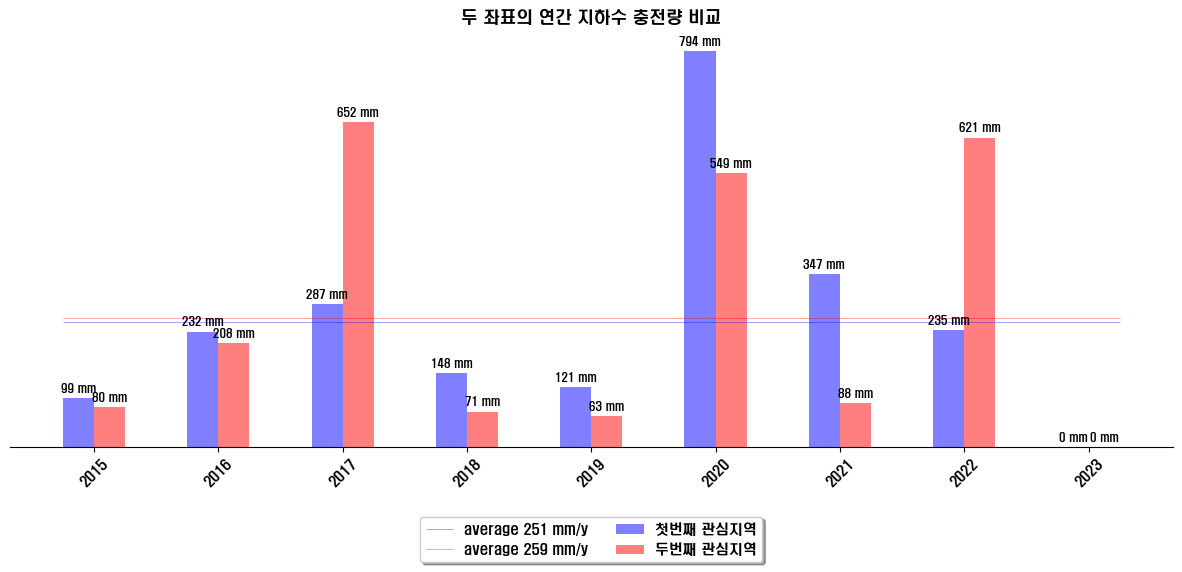

In [54]:
# 데이터 시각화를 위한 설정
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False) # y축 레이블 숨기기

# x축 레이블 위치 정의
x = np.arange(len(rdfy))

# 막대 너비 정의
width = 0.25

# 첫 번째 관심 위치의 지하수 재충전량에 대한 막대 그래프
rect1 = ax.bar(
    x - width / 2, rdfy.rech, width, label="첫번째 관심지역", color="blue", alpha=0.5
)

# 두 번째 관심 위치의 지하수 재충전량에 대한 막대 그래프
rect2 = ax.bar(
    x + width / 2,
    rdf2y.rech,
    width,
    label="두번째 관심지역",
    color="red",
    alpha=0.5,
)

# 각 막대에 레이블 추가 함수 정의
def autolabel_recharge(rects):
    """각 막대 위에 높이를 표시하는 텍스트 레이블을 부착합니다."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(int(height)) + " mm",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 수직 오프셋 3 포인트
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


autolabel_recharge(rect1)
autolabel_recharge(rect2)

# 두 관심 위치의 평균 연간 재충전량 계산
place1mean = int(rdfy["rech"].mean())
place2mean = int(rdf2y["rech"].mean())

# 첫 번째 위치의 평균 연간 재충전량을 나타내는 수평선 추가
ax.hlines(
    place1mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="blue",
    lw=0.5,
    label="average " + str(place1mean) + " mm/y",
    alpha=0.5,
)

# 두 번째 위치의 평균 연간 재충전량을 나타내는 수평선 추가
ax.hlines(
    place2mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="red",
    lw=0.5,
    label="average " + str(place2mean) + " mm/y",
    alpha=0.5,
)

# 제목 추가
ax.set_title("두 좌표의 연간 지하수 충전량 비교", fontsize=12)

# x/y축 레이블 및 틱 설정
ax.set_xticks(x)
x_labels = rdfy.index.year.tolist()
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

# 축 스파인 숨기기
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# 현재 축의 높이를 밑으로 10% 축소
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Add a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()